In [1]:
# link colab and drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
from torch.utils.data import Dataset, Sampler, DataLoader, SubsetRandomSampler
import random
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import torch.nn.functional as F
import copy
import matplotlib
from matplotlib.pyplot import *
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
torch.manual_seed(11)

##Functions

###Utils

In [3]:
class customDataset(Dataset):
  def __init__(self, rootPath, resize_transformation, data_augmentation_transformation=None, augment=True):
    ''' 
      @rootPath: path of the folder containing class subfolders
      @transformation: transformation to be applied to each image
      @data_augmentation: transformations to be applied to train images
      @augment: boolean indicating if data augmentation should be performed
    '''
    self.data = torchvision.datasets.ImageFolder(rootPath)
    self.transformation = resize_transformation
    self.data_augmentation = data_augmentation_transformation
    self.augment = True
    
  def __getitem__(self, key):
    
    true_class = self.data[key][1]
    im = Image.open(self.data.imgs[key][0])
    if self.augment and self.data_augmentation!=None:
      img_tensor = self.data_augmentation(im)
    else:
      img_tensor = self.transformation(im)

    return img_tensor, true_class

  def __len__(self):
    return len(self.data)

  def set_augment(self, value):
    self.augment = value

  def change_transformation(self, new_transformation):
    self.transformation = new_transformation

  def change_augmentation(self, new_augmentation):
    self.data_augmentation = new_augmentation

  def get_keys(self):
    return range(len(self.data))

In [4]:
def split(dataset, val_size):
    '''
    @ dataset: a customDataset object
    @ val_size: % of validation data
    '''
    index = list(dataset.get_keys())
    val_per_class = int(val_size*100)
    validation_index = []
    for i in range(15):
        idx = random.sample(range(100*i,100*(i+1)),val_per_class)
        validation_index= validation_index + idx
    train_index = list(set(index)-set(validation_index))

    train_sampler = SubsetRandomSampler(train_index)
    validation_sampler = SubsetRandomSampler(validation_index)

    return train_sampler, validation_sampler

In [5]:
def loaders(dataset, val_size, batch_size, num_workers):
  ''' 
    @dataset: a customDataset object
    @val_size: % validation data
    @batch_size: the number of examples in each batch
    @num_workers: number of subprocesses to use in the data loader
  '''

  train_sampler, validation_sampler = split(dataset, val_size)
  train_loader = DataLoader(dataset,
                            batch_size = batch_size,
                            sampler = train_sampler,
                            num_workers = num_workers)
  val_loader = DataLoader(dataset,
                          #batch_size = batch_size,
                          batch_size = int(val_size*len(dataset)),
                          sampler = validation_sampler,
                          num_workers = num_workers)
  return train_loader, val_loader

###CNN

In [6]:
def training_with_scheduler(net, trainLoader,valLoader, optimizer, scheduler, criterion, val_patience, validate_each):

  # here I save loss and accuracy
  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = []

  # early stopping
  best_net = copy.deepcopy(net.state_dict())
  best_loss = 100.0
  best_acc = 0
  worsening_count = 0
  
  #net.reset
  net.train()
  n_batches = len(trainLoader)

  for e in range(epochs):
      correct_classified = 0
      for i, data in enumerate(trainLoader):
    
        batch = data[0].to(device)
        batch = batch.float()
        labels = data[1].to(device)    

        optimizer.zero_grad() 
        outputs = net(batch)
        
        loss = criterion(outputs, labels) 
        train_loss.append(loss.item())
        predicted_class = torch.argmax(outputs, dim=1)
        correct_classified = correct_classified + sum((predicted_class==labels).int())
        acc = sum((predicted_class==labels).int())/batch.shape[0]
        train_accuracy.append(acc)

        loss.backward()
        optimizer.step()
        
        # parameter to decide how often to validate
        if i % validate_each ==0:
          with torch.no_grad():
            trainingSet.set_augment(False)
            valLoss, valAcc = validate(valLoader,net,criterion)
            # save validation loss and accuracy
            val_loss.append(valLoss)
            val_accuracy.append(valAcc)
            trainingSet.set_augment(True)
            
          # if validation loss increase (at least +1%), increase the counter
          if valLoss>best_loss:
              worsening_count = worsening_count+1
              # if I exceed the patience, early stop
              if worsening_count > val_patience:
                return [best_net, train_loss, val_loss, train_accuracy, val_accuracy]
          # else reset the counter and use actual validation loss as reference, save the net
          else:
             worsening_count = 0
             best_loss = valLoss
             best_acc = valAcc
             best_net = copy.deepcopy(net.state_dict())

          print("[LR]: {:.4f}\n".format(scheduler.get_last_lr()[0]))
          print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: t {}, v {},\t [ACC.]: t {},\t v {}".format(e, i, n_batches, loss.item(), valLoss, acc, valAcc))
      scheduler.step()
  return [best_net, train_loss, val_loss, train_accuracy, val_accuracy]

In [7]:
# validation 
def validate(valLoader, net, criterion):
  correct_count=0
  size = 0
  for i, data in enumerate(valLoader):
    batch = data[0].to(device)
    batch = batch.float()
    labels = data[1].to(device)    

    outputs = net(batch)
    loss = criterion(outputs, labels) 
    predicted_class = torch.argmax(outputs, dim=1)
    correct_count = correct_count + sum((predicted_class==labels).int())
    size = size + batch.shape[0]
  acc = correct_count/size
  return [loss.item(), acc]

In [8]:
def plot_results(train_data, validation_data, color='C0', isAccuracy = False):
  
  # create figure
  fig = figure(figsize=(20,10))
  xlim(0,len(train_data)+len(trainLoader))
    
  # color background
  for i in range(0,epochs):
    if (i%2 != 0):
      axvspan(i*len(trainLoader), i*len(trainLoader)+len(trainLoader), facecolor='silver', alpha=0.5)
  
  # lines and legend
  label1 = 'training_{}'.format('accuracy' if isAccuracy else 'loss')
  label2 = 'validation_{}'.format('accuracy' if isAccuracy else 'loss')  
  plot(range(0,len(train_data)), train_data, color, label=label1)
  plot(range(0,len(train_data), 5), validation_data, 'black', linestyle ='--', dashes=(5, 5),  marker='o',label=label2)
  axvline((len(validation_data)-(patience+1))*validate_each, color='red', linestyle = '--')
  legend(fontsize=18)

In [9]:
resize = transforms.Compose([
                                        transforms.Resize([64,64], interpolation=Image.BILINEAR),
                                        transforms.ToTensor()
])

def resize_transformation(img):
  i = resize(img)
  i =i*255
  return i

In [10]:
flip = transforms.Compose([
                                          transforms.Resize([64,64], interpolation=Image.BILINEAR),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor()
])

def flip_transformation(img):
  i = flip(img)
  i =i*255
  return i

In [11]:
# test
def testing(net, testLoader):
  net.eval()

  with torch.no_grad():
    # to save true and predicted classes
    true_class = []
    predicted_class = []

    for i, data in enumerate(testLoader):
      image = data[0].to(device)
      image = image.float()
      label = data[1].to(device)
      true_class.append(label)

      output = net(image)    
      pred_class = torch.argmax(output, dim=1)
      predicted_class.append(pred_class)
    
  # needed transformations
  predicted_class = torch.cat(predicted_class)
  true_class = torch.cat(true_class)
  return [true_class, predicted_class]

In [12]:
def get_accuracy(true, predicted):
  return (sum((predicted==true).int())/len(true)).item()

In [13]:
# testing
def test_results(true, predicted):
  # accuracy and confusion matrix
  print("Test Accuracy: ", get_accuracy(true, predicted))
  conf_matrix = confusion_matrix(true, predicted, normalize='true')
  # plot
  disp = ConfusionMatrixDisplay(conf_matrix, dataTest.classes)
  fig, ax = subplots(figsize=(15,15))
  ax.title.set_text("Confusion Matrix")
  disp.plot(xticks_rotation='vertical', ax = ax)

##Imprt Data

In [14]:
# if available use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cpu


In [15]:
trainPath = '/content/drive/My Drive/CV_project/Images/train'
testPath =  '/content/drive/My Drive/CV_project/Images/test'
dataTrain = torchvision.datasets.ImageFolder(trainPath)
dataTest = torchvision.datasets.ImageFolder(testPath)

In [16]:
# datasets
batch_size = 32
num_workers = 1
trainingSet = customDataset(trainPath, resize_transformation, flip_transformation)
trainLoader, valLoader = loaders(trainingSet, 0.15, batch_size, num_workers)
testSet = customDataset(testPath, resize_transformation, augment=False)
testLoader = DataLoader(testSet, batch_size = batch_size, shuffle=False, num_workers=num_workers)

##Training

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.input_dim = 1 * 64 * 64
        self.n_classes = 15
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate')  
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv1.bias)     

        self.BN1 = nn.BatchNorm2d(num_features=8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.maxpooling = nn.MaxPool2d(kernel_size=2,stride=2)  

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv2.bias)

        self.BN2 = nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=3, padding_mode='replicate')
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv3.bias)

        self.BN3 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.fc1 = nn.Linear(16*16*32,15)
        torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.fc1.bias)

        self.dropout = nn.Dropout(0.25)


    def forward(self, x, verbose=False):
      x = self.conv1(x)
      x = self.BN1(x)
      x = F.relu(x)
      x = self.maxpooling(x) 
      #x = self.dropout(x)
      x = self.conv2(x)
      x = self.BN2(x)
      x = F.relu(x)
      x = self.maxpooling(x)
      #x = self.dropout(x)
      x = self.conv3(x)
      x = self.BN3(x)
      x = F.relu(x)
      x = self.dropout(x)
      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      # no softmax because crossentropy loss performs it
      return x

In [25]:
net = CNN()
net.to(device)

# parameters
lr = 0.001
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay=0.2)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
patience = 15
validate_each = 5

trained_net, train_loss, valid_loss, train_acc, valid_acc = training_with_scheduler(net, trainLoader, valLoader, optimizer, lr_scheduler, criterion, patience, validate_each)
net.load_state_dict(trained_net)

[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 0/40, [LOSS]: t 2.88431453704834, v 3.8148627281188965,	 [ACC.]: t 0.09375,	 v 0.1111111119389534
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 5/40, [LOSS]: t 3.0358638763427734, v 3.2408382892608643,	 [ACC.]: t 0.125,	 v 0.12888889014720917
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 10/40, [LOSS]: t 3.13555908203125, v 2.718824863433838,	 [ACC.]: t 0.1875,	 v 0.2133333384990692
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 15/40, [LOSS]: t 2.4062013626098633, v 2.4519600868225098,	 [ACC.]: t 0.375,	 v 0.2622222304344177
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 20/40, [LOSS]: t 2.151054859161377, v 2.3941850662231445,	 [ACC.]: t 0.40625,	 v 0.2800000011920929
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 25/40, [LOSS]: t 2.2576680183410645, v 2.3217267990112305,	 [ACC.]: t 0.28125,	 v 0.2711111009120941
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 30/40, [LOSS]: t 2.054266929626465, v 2.1123201847076416,	 [ACC.]: t 0.4375,	 v 0.36888888478279114
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 35/40, [LOSS]: t 2.3918714

<All keys matched successfully>

In [ ]:
#torch.save(net.state_dict(), '/content/drive/MyDrive/Nets/final_CNN.pt')
#net = CNN()
#net.load_state_dict(torch.load('/content/drive/MyDrive/Nets/final_CNN.pt'))

##Results

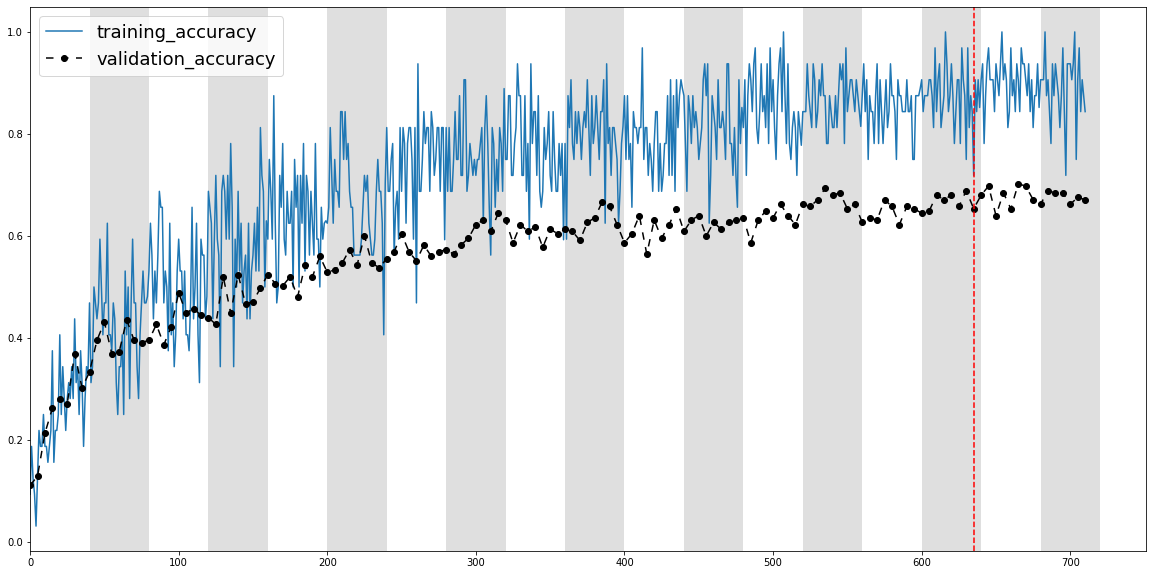

In [26]:
plot_results(train_acc, valid_acc, 'C0', True)
#savefig('/content/drive/MyDrive/Nets/final_accuracy.png')

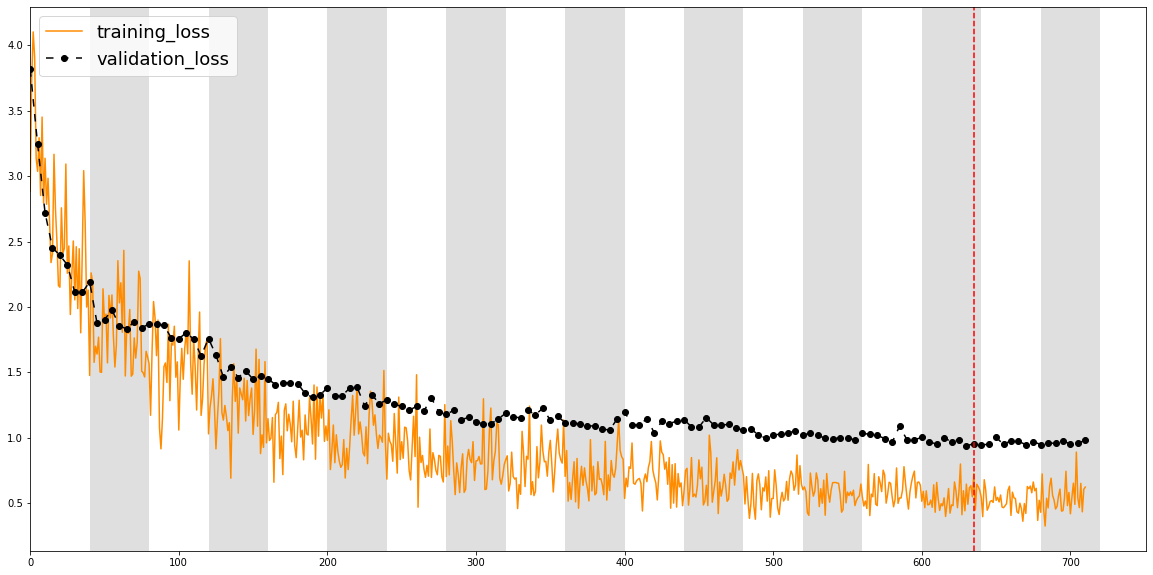

In [27]:
plot_results(train_loss, valid_loss, 'darkorange', False)
#savefig('/content/drive/MyDrive/Nets/final_loss.png')

Test Accuracy:  0.6388610005378723


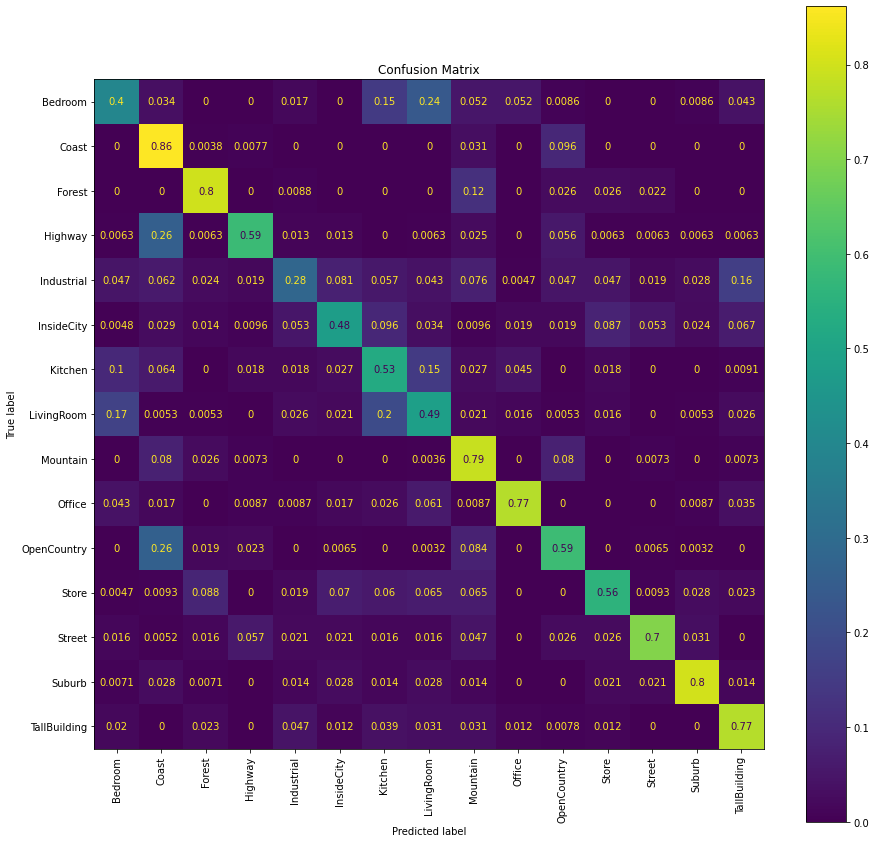

In [28]:
# testing
true_class, predicted_class = testing(net, testLoader)

test_results(true_class, predicted_class)
#savefig('/content/drive/MyDrive/Nets/final_cmatrix_norm.png')
#savefig('/content/drive/MyDrive/Nets/final_cmatrix_abs.png')

## Optional: Data augmentation

### Functions

In [17]:
image = dataTrain[0][0]

In [18]:
image_np = np.asarray(image)

In [30]:
import math
def random_rotation(img_np, angle, prob):
  if(random.random() < prob):
    #image padding
    (w, h) = image_np.shape[:2] 
    diagonal = math.sqrt(w**2 + h**2)
    w_pad = math.ceil(diagonal - w)
    h_pad = math.ceil(diagonal - h)
    imagepad = np.zeros((w+w_pad, h+h_pad,3))
    imagepad[math.ceil(w_pad/2):(math.ceil(w_pad/2)+w),math.ceil(h_pad/2):(math.ceil(h_pad/2)+h),:] = image_np

    theta = np.radians(angle)

    (w, h) = imagepad.shape[:2] 
    (cX, cY) = (w // 2, h // 2) #center
    imagerot = np.zeros((imagepad.shape))

    # rotation
    for i in range(imagerot.shape[1]):
      for j in range(imagerot.shape[0]):
        x= (i-cX)*np.cos(theta)+(j-cY)*np.sin(theta)
        y=-(i-cX)*np.sin(theta)+(j-cY)*np.cos(theta)
        x=round(x)+cX
        y=round(y)+cY
        if (x>=0 and y>= 0 and x<imagepad.shape[0] and y<imagepad.shape[1]):
          imagerot[i,j]=imagepad[x,y]
    return np.uint8(imagerot)
  return img_np

In [31]:
def random_crop(img_np, new_size):
  assert img_np.shape[0] >= new_size
  assert img_np.shape[1] >= new_size
  x = random.randint(0, img_np.shape[0] - new_size)
  y = random.randint(0, img_np.shape[1] - new_size)
  img_np = img_np[x:x+new_size,y:y+new_size]
  return img_np

In [32]:
def random_horizontal_flip(img_np, prob):
  if(random.random() < prob):
    img_np = img_np[:,::-1]
    #img_np = np.fliplr(img_np)
  return img_np

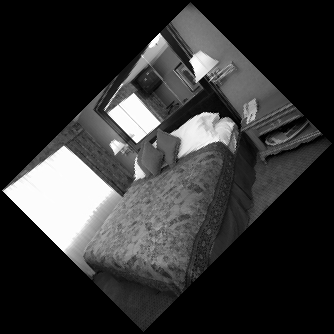

In [29]:
Image.fromarray(random_rotation(image_np, 45, 0.5))

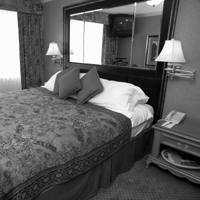

In [ ]:
Image.fromarray(random_crop(image_np,200))

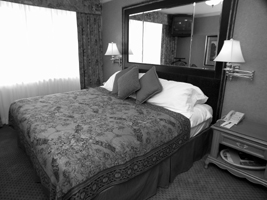

In [ ]:
Image.fromarray(random_horizontal_flip(image_np, 0.5))

In [61]:
def augmentation_transformation2(img):
  img_np = np.asarray(img)
  # transformations
  img_np = random_crop(img_np, 200)
  img_np = random_rotation(img_np, 5, 1)
  img_np = random_horizontal_flip(img_np, 1)
  img_np = torch.from_numpy(img_np.copy())
  t = transforms.Resize([64,64],interpolation=Image.BILINEAR)
  img_np = t(img_np)
  img_np.unsqueeze_(0)
  return img_np

In [62]:
x = augmentation_transformation2(image)

In [63]:
x.size()

torch.Size([1, 334, 64, 64])

### Already implemented function

In [ ]:
augmentation = transforms.Compose([
                                   transforms.RandomHorizontalFlip(p=0.5),
                                   transforms.RandomCrop((200,200)),
                                   transforms.RandomRotation(5),
                                   #transforms.Resize([64,64], interpolation=Image.BILINEAR),
                                   #transforms.ToTensor()
])

def augmentation_transformation(img):
  i = augmentation(img)
  i =i*255
  return i

In [56]:
augmentedTrainingSet = customDataset(trainPath, resize_transformation, augmentation_transformation2)
trainLoader, valLoader = loaders(augmentedTrainingSet, 0.15, batch_size, num_workers)

In [57]:
net_aug = CNN()
net_aug.to(device)

# parameters
lr = 0.001
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_aug.parameters(), lr = lr, weight_decay=0.2)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
patience = 15
validate_each = 5

trained_net_aug, train_loss, valid_loss, train_acc, valid_acc = training_with_scheduler(net_aug, trainLoader, valLoader, optimizer, lr_scheduler, criterion, patience, validate_each)
net_aug.load_state_dict(trained_net_aug)

AssertionError: ignored

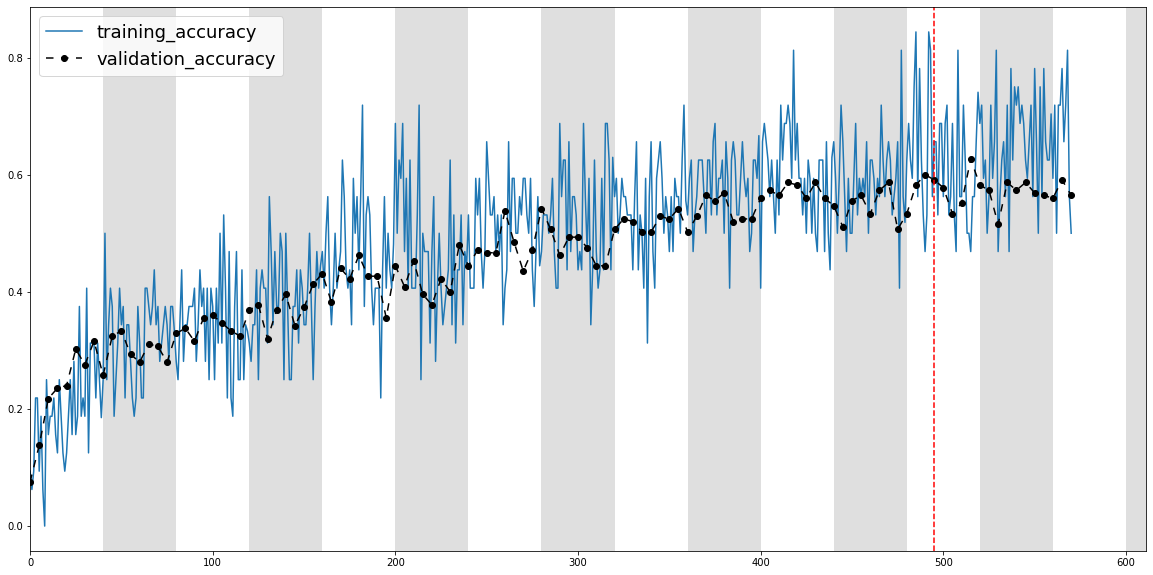

In [ ]:
plot_results(train_acc, valid_acc, 'C0', True)

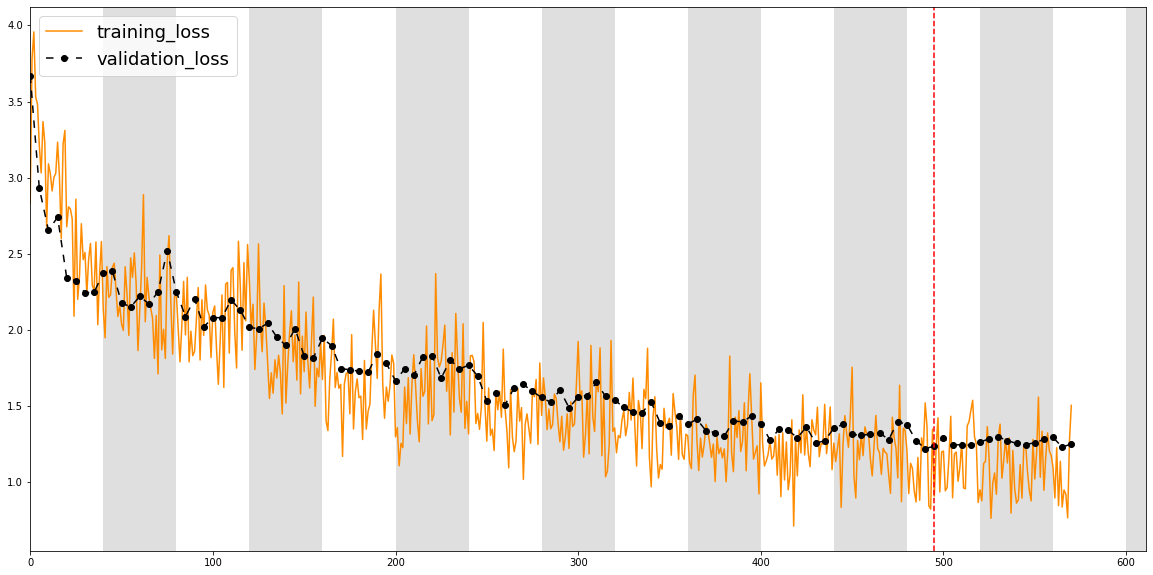

In [ ]:
plot_results(train_loss, valid_loss, 'darkorange', False)

Test Accuracy:  0.5762144327163696


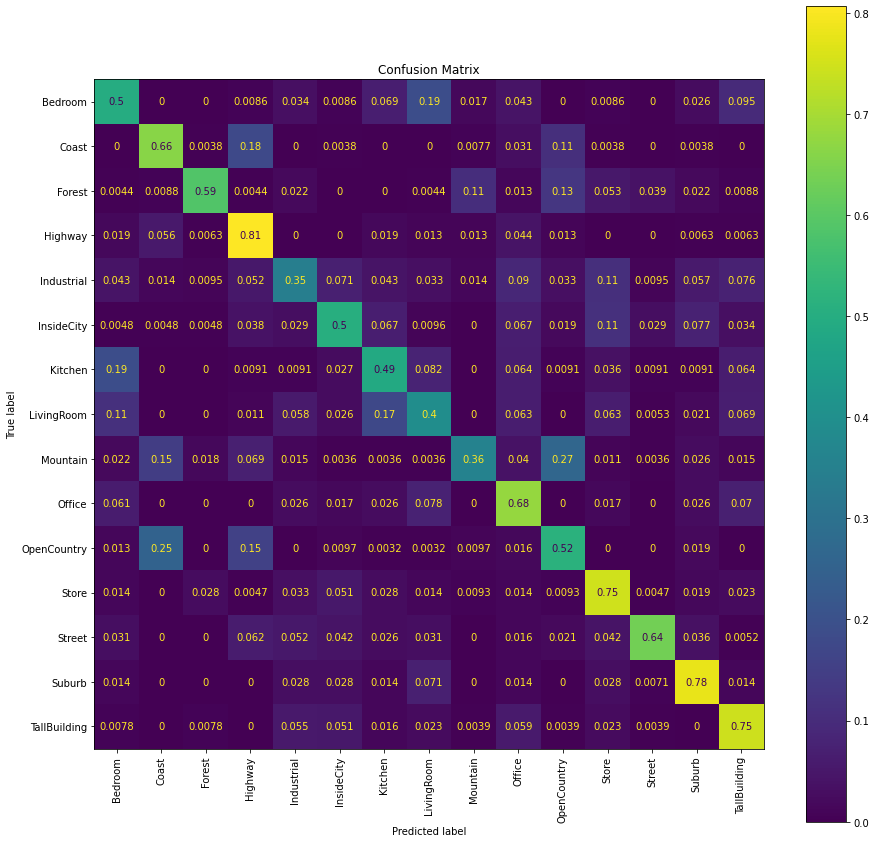

In [ ]:
# testing
true_class, predicted_class = testing(net_aug, testLoader)

test_results(true_class, predicted_class)

##Optional: Bigger CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.input_dim = 1 * 64 * 64
        self.n_classes = 15
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate')  
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv1.bias)     

        self.BN1 = nn.BatchNorm2d(num_features=8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate')  
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv2.bias) 

        self.maxpooling = nn.MaxPool2d(kernel_size=2,stride=2)  

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv3.bias)

        self.BN2 = nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        torch.nn.init.normal_(self.conv4.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv4.bias)

        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=3, padding_mode='replicate')
        torch.nn.init.normal_(self.conv5.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv5.bias)

        self.BN3 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=3, padding_mode='replicate')
        torch.nn.init.normal_(self.conv6.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv6.bias)

        self.fc1 = nn.Linear(16*16*32,15)
        torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.fc1.bias)

        self.dropout = nn.Dropout(0.25)


    def forward(self, x, verbose=False):
      x = self.conv1(x)
      x = self.BN1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = self.BN1(x)
      x = F.relu(x)
      x = self.maxpooling(x)
      x = self.conv3(x)
      x = self.BN2(x)
      x = F.relu(x)
      x = self.conv4(x)
      x = self.BN2(x)
      x = F.relu(x)
      x = self.maxpooling(x)
      x = self.conv5(x)
      x = self.BN3(x)
      x = F.relu(x)
      x = self.conv6(x)
      x = self.BN3(x)
      x = F.relu(x)
      x = self.dropout(x)
      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      # no softmax because crossentropy loss performs it
      return x



In [ ]:
net_big = CNN()
net_big.to(device)

# parameters
lr = 0.001
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_big.parameters(), lr = lr, weight_decay=0.2)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
patience = 15
validate_each = 5

trained_net_big, train_loss, valid_loss, train_acc, valid_acc = training_with_scheduler(net_big, trainLoader, valLoader, optimizer, lr_scheduler, criterion, patience, validate_each)
net_big.load_state_dict(trained_net_big)

[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 0/40, [LOSS]: t 2.943288803100586, v 3.586799383163452,	 [ACC.]: t 0.09375,	 v 0.08444444090127945
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 5/40, [LOSS]: t 3.5497565269470215, v 3.0713157653808594,	 [ACC.]: t 0.09375,	 v 0.1599999964237213
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 10/40, [LOSS]: t 2.9451115131378174, v 2.976332664489746,	 [ACC.]: t 0.21875,	 v 0.12444444745779037
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 15/40, [LOSS]: t 3.2133188247680664, v 2.7487475872039795,	 [ACC.]: t 0.125,	 v 0.2133333384990692
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 20/40, [LOSS]: t 2.5856614112854004, v 2.6204307079315186,	 [ACC.]: t 0.21875,	 v 0.19111111760139465
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 25/40, [LOSS]: t 2.5782687664031982, v 2.63114857673645,	 [ACC.]: t 0.125,	 v 0.19555555284023285
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 30/40, [LOSS]: t 2.6352157592773438, v 2.840904712677002,	 [ACC.]: t 0.25,	 v 0.1688888818025589
[LR]: 0.0010

[EPOCH]: 0, [BATCH]: 35/40, [LOSS]: t 2.74769

<All keys matched successfully>

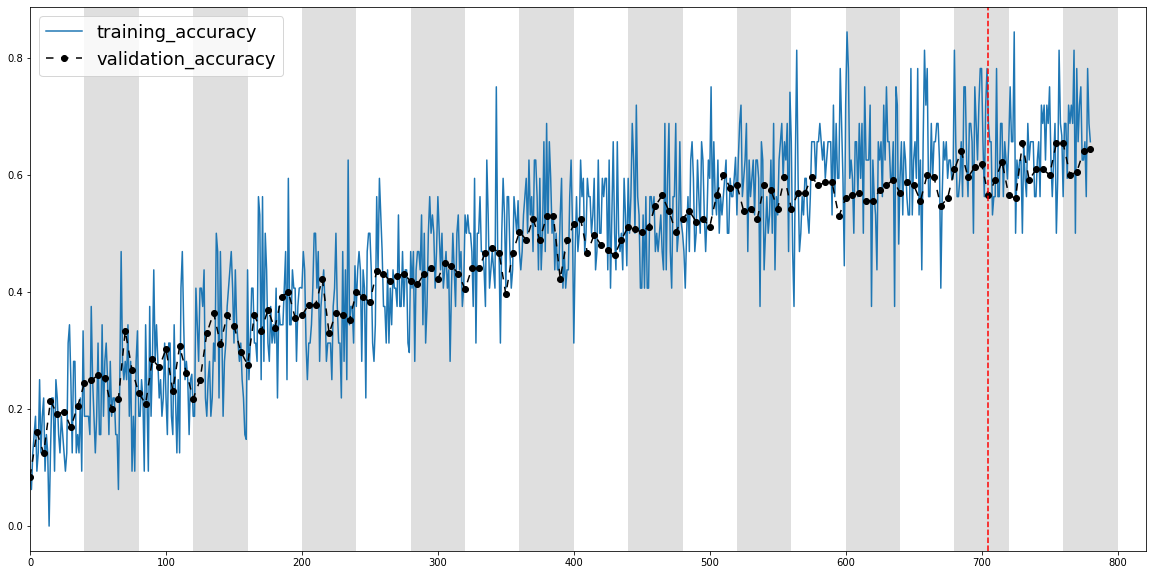

In [ ]:
plot_results(train_acc, valid_acc, 'C0', True)

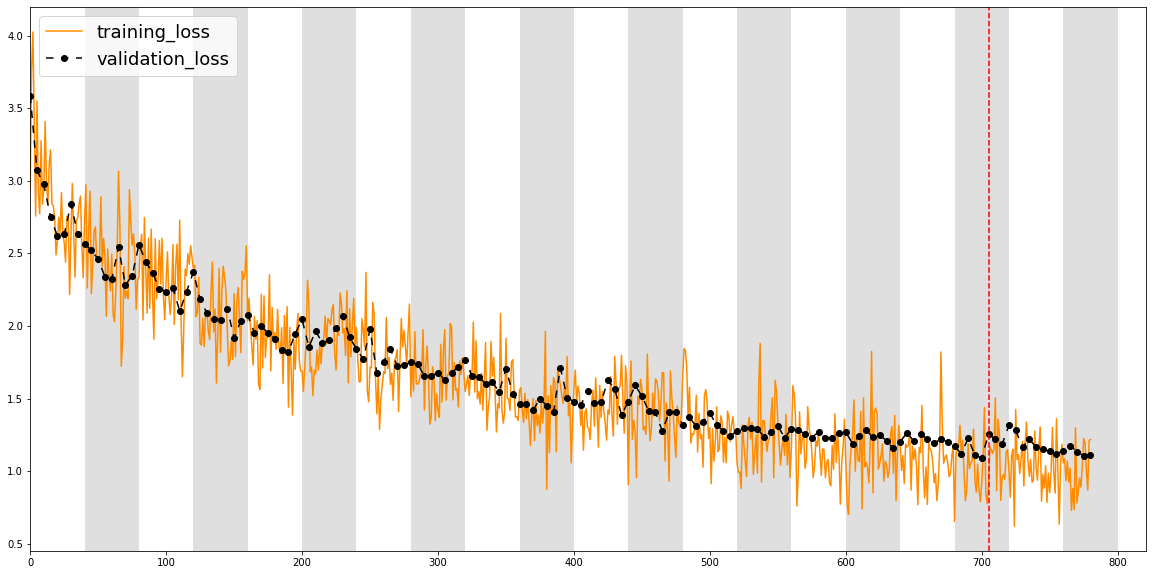

In [ ]:
plot_results(train_loss, valid_loss, 'darkorange', False)

Test Accuracy:  0.1443886160850525


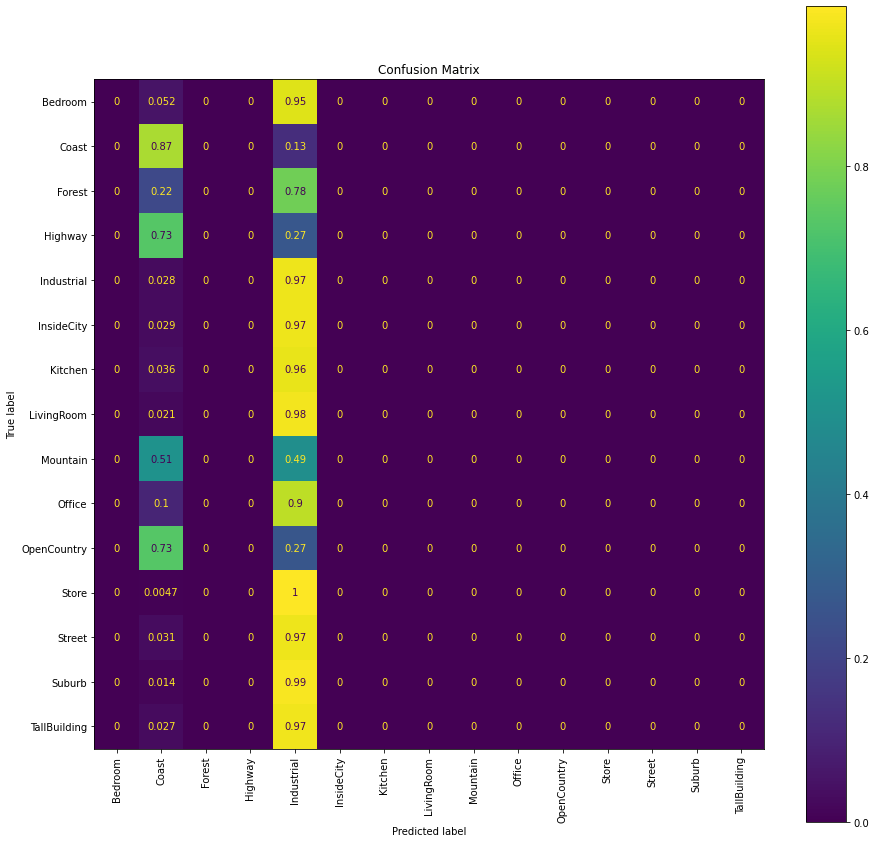

In [ ]:
# testing
true_class, predicted_class = testing(net_big, testLoader)

test_results(true_class, predicted_class)